In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GRU, Embedding, Input, concatenate, Conv2D
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, roc_curve

## Preprocess

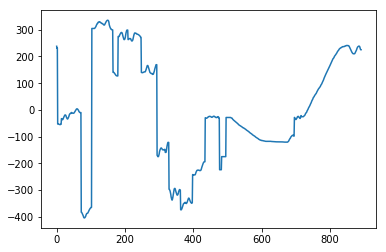

In [3]:
from data import preprocess
data = preprocess.preprocess('data/raw/CD_PD.mat')
label = data['diagnosis'].astype('int32')

def normalize_mean(data):
    for i in range(len(data)):
        data[i] = data[i] - np.mean(data[i])
    return data

# Normalize Mean
data_x = normalize_mean(data['x'])
data_y = normalize_mean(data['y'])
data_p = normalize_mean(data['p'])

plt.plot(data['x'][0])

## FFT

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


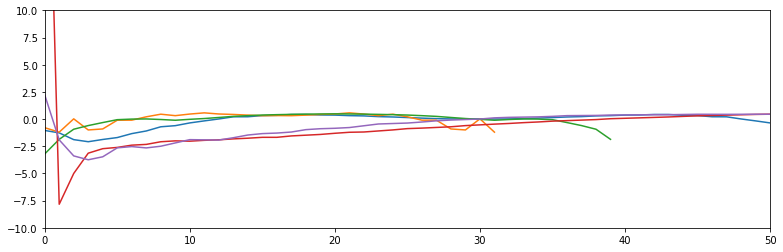

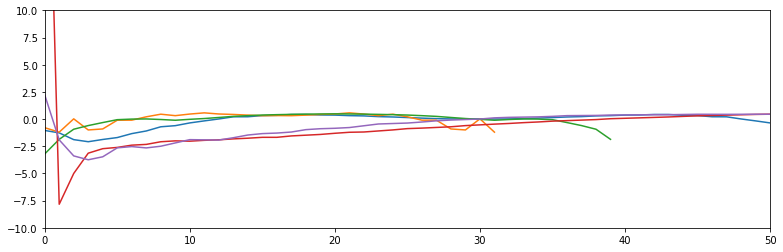

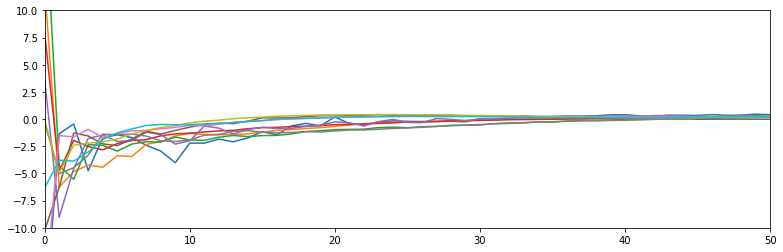

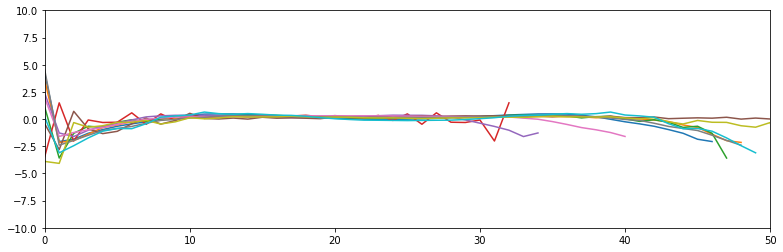

[array([ 4.21957623+0.j        , -2.06642178-0.01059711j,
        -1.85372733-0.41758331j, -1.30478716-0.45774297j,
        -0.96683468-0.68890235j, -0.65882387-0.88558j   ,
        -0.43911299-0.96920125j, -0.24845309-0.92422643j,
        -0.0178636 -0.80891546j,  0.21121736-0.73540848j,
         0.34423529-0.62844487j,  0.45766935-0.52656253j,
         0.47485688-0.40717654j,  0.47252598-0.27368781j,
         0.42681354-0.13407129j,  0.37784554-0.04335106j,
         0.31328416+0.03149553j,  0.24404005+0.08312757j,
         0.18177381+0.11243702j,  0.12259946+0.11831992j,
         0.06876167+0.10752484j,  0.02394547+0.08970664j,
        -0.00506372+0.05910772j, -0.02413708+0.02063079j,
        -0.02413708-0.02063079j, -0.00506372-0.05910772j,
         0.02394547-0.08970664j,  0.06876167-0.10752484j,
         0.12259946-0.11831992j,  0.18177381-0.11243702j]),
 array([ 3.59334604+0.00000000e+00j, -2.1451736 +1.38165327e+00j,
        -1.98337229-3.95811534e-01j, -1.39207466-1.94125838e-0

In [55]:
WINDOW_SIZE = 30

def signal_fft(signal):
    res = []
    plt.figure(figsize=(15,5))
    for i in range(0, len(signal), WINDOW_SIZE):
        sig_fft = np.fft.fft(signal[i: i + WINDOW_SIZE])
        res.append(sig_fft)
        plt.plot(sig_fft)
    plt.show()
    return res

def signal_fft_component(signal, pt, plot=False, n_lines=10):
    res, temp = [], []
    c = 0
    if plot: 
        plt.figure(figsize=(13, 4))
        plt.xlim(0, 50)
        plt.ylim(-10, 10)
    for i in range(len(signal)):
        if pt[i] != 2:
            if len(temp) > WINDOW_SIZE:
                sig_fft = np.fft.fft(temp)
                res.append(sig_fft[:WINDOW_SIZE])
                if plot and c < n_lines: 
                    plt.plot(sig_fft)
                    c += 1
            temp = []
        else:
            temp.append(signal[i])
    if plot: plt.show()
    return res

# Non PD
signal_fft_component(data['p'][0], data['pt'][0], True)
signal_fft_component(data['p'][55], data['pt'][55], True)

# PD
signal_fft_component(data['p'][191], data['pt'][191], True)
signal_fft_component(data['p'][170], data['pt'][170], True)

In [30]:
def signal_preprocess(data, label, pt_data):
    X_data, y_data = [], []
    for i in range(len(data)):
        fft_com = signal_fft_component(data[i], pt_data[i])
        X_data += fft_com
        y_data += [label[i]] * len(fft_com)      
    return np.array(X_data), np.array(y_data)

X_data, y_data = signal_preprocess(data['p'], label, data['pt'])

In [33]:
print(X_data.shape, y_data.shape)

(3048, 20) (3048,)


In [68]:
from tensorflow.keras.layers import *

ModuleNotFoundError: No module named 'tensorflow.keras'

In [63]:
def get_cnn_model(window_size):
    adam = Adam(lr=1e-4)
    model = Sequential()
    model.add(Conv1D(16, kernel_size=(1,5)), input_shape=(window_size,))
    model.add(MaxPooling1D(pool_size=6))
    model.add(Conv1D(16, kernel_size=(1,5)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam)
    model.summary()
    return model

model = get_cnn_model(WINDOW_SIZE)
model.summary()

NameError: name 'Conv1D' is not defined

In [45]:
# Split train test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

model = get_cnn_model(WINDOW_SIZE)
model.fit(X_train, y_train, batch_size=32, 
    epochs=150, verbose=1, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test)

Train on 2438 samples, validate on 610 samples
Epoch 1/150
 192/2438 [=>............................] - ETA: 5s - loss: 0.7315/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
2438/2438 [==============================] - 1s 315us/step - loss: 0.7015 - val_loss: 0.6606
Epoch 2/150
2438/2438 [==============================] - 0s 133us/step - loss: 0.6624 - val_loss: 0.6459
Epoch 3/150
2438/2438 [==============================] - 0s 110us/step - loss: 0.6535 - val_loss: 0.6399
Epoch 4/150
2438/2438 [==============================] - 0s 87us/step - loss: 0.6495 - val_loss: 0.6367
Epoch 5/150
2438/2438 [==============================] - 0s 116us/step - loss: 0.6467 - val_loss: 0.6346
Epoch 6/150
2438/2438 [==============================] - 0s 96us/step - loss: 0.6444 - val_loss: 0.6332
Epoch 7/150
2438/2438 [=====

0.6200368939853106

610/610 [==============================] - 0s 17us/step
              precision    recall  f1-score   support

       No PD       0.65      0.79      0.71       323
          PD       0.69      0.52      0.59       287

   micro avg       0.66      0.66      0.66       610
   macro avg       0.67      0.66      0.65       610
weighted avg       0.67      0.66      0.66       610

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0.6639344262295082

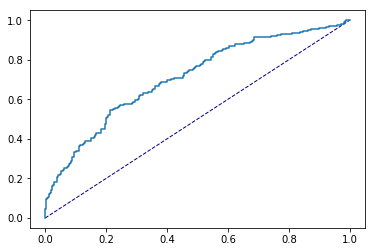

In [48]:
def eval_score(model, X_test, y_test, THRESHOLD = 0.5, report = False):
    y_pred = model.predict(X_test, batch_size=64, verbose=1).reshape(-1)
    y_pred_bool = np.where(y_pred < THRESHOLD, 0, 1)
    if report:
        print(classification_report(y_test, y_pred_bool, target_names=['No PD', 'PD']))
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.plot(fpr, tpr)
        
    acc = accuracy_score(y_test, y_pred_bool)
    return acc

eval_score(model, X_test, y_test, report=True)